# Compliance Radar – Main Notebook

Machine Learning 2025/2026 – LUISS Guido Carli

This notebook follows the project structure required by the course:
1. Data loading
2. Exploratory Data Analysis (EDA)
3. Preprocessing & feature engineering
4. Model training & cross-validation
5. Evaluation & interpretability
6. Conclusions & insights


## 0. Setup & Imports

Run this cell first to load all required libraries.

In [1]:
# Clone the GitHub repository into Colab
!rm -rf Machine-Learning-2025-2026---Group-Project
!git clone https://github.com/personallypetra/Machine-Learning-2025-2026---Group-Project.git
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sqlalchemy import create_engine, inspect

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    roc_curve,
    auc
)

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (8, 5)


Cloning into 'Machine-Learning-2025-2026---Group-Project'...
remote: Enumerating objects: 51, done.
remote: Counting objects: 100% (51/51), done.
remote: Compressing objects: 100% (45/45), done.
remote: Total 51 (delta 17), reused 11 (delta 2), pack-reused 0 (from 0)
Receiving objects: 100% (51/51), 324.80 KiB | 1.78 MiB/s, done.
Resolving deltas: 100% (17/17), done.


## 1. Data Loading

We load the SQLite database `org_compliance_data.db` from the `data/` folder and inspect the available tables.

In [2]:
print("Current Directory:", os.getcwd())
print("Top-level files:", os.listdir("."))

candidates = ["data/org_compliance_data.db",
    "Machine-Learning-2025-2026---Group-Project/data/org_compliance_data.db",
    "/content/data/org_compliance_data.db",]

db_path = None
for p in candidates:
  if os.path.exists(p):
    db_path = p
    break

if db_path is None:
  raise FileNotFoundError("Could not find org_compliance_data.db."
  "Make sure the repo files are available in Colab Or upload the db to colab")

print("DB path found:", db_path)

engine = create_engine(f"sqlite:///{db_path}")
inspector = inspect(engine)

tables = inspector.get_table_names()
print("Tables in the database", tables)



Current Directory: /content
Top-level files: ['.config', 'Machine-Learning-2025-2026---Group-Project', 'sample_data']
DB path found: Machine-Learning-2025-2026---Group-Project/data/org_compliance_data.db
Tables in the database ['data_dictionary', 'departments', 'high_risk_departments', 'risk_summary_by_division']


### Loading main features table

In [3]:
df_dept = pd.read_sql("SELECT * FROM departments;", engine)
print(df_dept.shape)
df_dept.head()

(709, 37)


,dept_id,dept_name,dept_category,division,dept_type,dept_age_years,location_type,team_size,reporting_structure,manager_experience_level,...,resource_availability_score,external_interactions_frequency,risk_exposure_operational,risk_exposure_financial,operational_health_index,reporting_gaps_annual,audit_score_q1,audit_score_q2,compliance_score_final,overall_risk_score
0,DEPT-1620,Core Compliance,Financial_Reporting,Corporate_HQ,Operations,8.0,Remote,Large,Centralized,2.0,...,2.0,3.0,1.0,NaN,5.0,NaN,55.0,55.0,65.0,12.0
1,DEPT-1133,Digital Governance,Financial_Reporting,Corporate_HQ,Compliance,8.0,Urban,Large,Centralized,2.0,...,4.0,NaN,2.0,2.0,1.0,26.0,NaN,40.0,NaN,43.0
2,DEPT-4917,Central Hub,Operational_Compliance,None,None,NaN,None,None,None,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,DEPT-6959,Compliance - Legacy Region,Financial_Reporting,Corporate_HQ,Support,8.0,Urban,Large,Centralized,4.0,...,3.0,4.0,1.0,1.0,5.0,2.0,70.0,75.0,85.0,11.0
4,DEPT-4312,West Internal Controls,Financial_Reporting,Corporate_HQ,Operations,6.0,Urban,Small,Centralized,1.0,...,4.0,2.0,1.0,1.0,5.0,2.0,45.0,45.0,45.0,11.0


In [4]:
df_risk = pd.read_sql("SELECT* FROM high_risk_departments;", engine)
print(df_risk.shape)
df_risk.head()

(201, 37)


,dept_id,dept_name,dept_category,division,dept_type,dept_age_years,location_type,team_size,reporting_structure,manager_experience_level,...,resource_availability_score,external_interactions_frequency,risk_exposure_operational,risk_exposure_financial,operational_health_index,reporting_gaps_annual,audit_score_q1,audit_score_q2,compliance_score_final,overall_risk_score
0,DEPT-1133,Digital Governance,Financial_Reporting,Corporate_HQ,Compliance,8.0,Urban,Large,Centralized,2.0,...,4.0,NaN,2.0,2.0,1.0,26.0,NaN,40.0,NaN,43.0
1,DEPT-4312,West Internal Controls,Financial_Reporting,Corporate_HQ,Operations,6.0,Urban,Small,Centralized,1.0,...,4.0,2.0,1.0,1.0,5.0,2.0,45.0,45.0,45.0,11.0
2,DEPT-3347,Business Integrity - Central Region,Financial_Reporting,Corporate_HQ,Operations,6.0,Urban,Small,Centralized,2.0,...,4.0,4.0,3.0,5.0,5.0,6.0,45.0,50.0,50.0,53.0
3,DEPT-2554,Central Team,Financial_Reporting,Corporate_HQ,Support,5.0,Urban,Small,Autonomous,3.0,...,3.0,4.0,4.0,4.0,1.0,0.0,65.0,60.0,65.0,40.0
4,DEPT-3151,Compliance - East Region,Financial_Reporting,Corporate_HQ,None,8.0,Urban,Small,Centralized,3.0,...,2.0,4.0,NaN,4.0,4.0,10.0,50.0,50.0,50.0,35.0


In [5]:
df_risk.columns

Index(['dept_id', 'dept_name', 'dept_category', 'division', 'dept_type',
       'dept_age_years', 'location_type', 'team_size', 'reporting_structure',
       'manager_experience_level', 'supervisor_experience_level',
       'primary_function', 'secondary_function', 'creation_reason',
       'oversight_body', 'reporting_lag_days', 'training_hours_quarterly',
       'violations_past_3years', 'remediation_plan_active',
       'executive_support', 'external_consulting', 'engagement_programs',
       'onboarding_program', 'improvement_commitment', 'digital_systems',
       'external_partnerships', 'interdept_collaboration_score',
       'resource_availability_score', 'external_interactions_frequency',
       'risk_exposure_operational', 'risk_exposure_financial',
       'operational_health_index', 'reporting_gaps_annual', 'audit_score_q1',
       'audit_score_q2', 'compliance_score_final', 'overall_risk_score'],
      dtype='object')

Once we are sure that df_risk has been made, we can safely do:


In [6]:
df = df_dept.copy()
print(df.shape)
df.head()
df["high_risk"] = df["dept_id"].isin(df_risk["dept_id"]).astype(int)
df["high_risk"].value_counts()

(709, 37)


,count
high_risk,
0,492
1,217


Departments listed in the 'high_risk_departments' table are labeled as high compliance risk (1).


_________________________________________________________________________
This approach reflects how compliance teams typically identify high-risk units based on prior audits or investigations.



We have 709 departments overall, of which 217 (approx. 30.6%) belong to high risk group. Hence, rest 492 (approx. 69.4%) belong to low/normal risk group.

Given this, our classification problem is moderately imbalanced. In practice, this means that we are going to use **precision, recall and F1**(we are not relying solely on accuracy).

Moreover, we are going to focus on recall for compliance since overlooking/missing high-risk units is costly.

In [7]:
df.loc[df["high_risk"] == 1, "dept_id"].head()

,dept_id
1,DEPT-1133
4,DEPT-4312
5,DEPT-3347
8,DEPT-2554
11,DEPT-3151


So far:
- corrected data is loaded,
- we have join key (*dept_id*),
- we have target(*high_risk*)

### Defining feature matrix and target

We are using all department-level variables as predictors, excluding indentifiers and the target label.

In [8]:
y = df["high_risk"]

X = df.drop(columns = ["dept_id", "dept_name", "high_risk"])

print("X shape:", X.shape)
print("y distribution (%):")
print((y.value_counts(normalize=True)*100).round(2))

X shape: (709, 35)
y distribution (%):
high_risk
0    69.39
1    30.61
Name: proportion, dtype: float64


### Train / Test split

We are using 80/20 stratified split to preserve the proportion of high-risk departments.

This provides a fair baseline evaluation before cross-validation.




In [9]:
missing_ratio = X.isna().mean()
cols_to_drop = missing_ratio[missing_ratio > 0.4].index.tolist()

print("Dropping columns due to high missingness:", cols_to_drop)

X = X.drop(columns = cols_to_drop)

Dropping columns due to high missingness: ['dept_type', 'dept_age_years', 'location_type', 'team_size', 'reporting_structure', 'manager_experience_level', 'supervisor_experience_level', 'primary_function', 'secondary_function', 'creation_reason', 'oversight_body', 'reporting_lag_days', 'training_hours_quarterly', 'violations_past_3years', 'remediation_plan_active', 'executive_support', 'external_consulting', 'engagement_programs', 'onboarding_program', 'improvement_commitment', 'digital_systems', 'external_partnerships', 'interdept_collaboration_score', 'resource_availability_score', 'external_interactions_frequency', 'risk_exposure_operational', 'risk_exposure_financial', 'operational_health_index', 'reporting_gaps_annual', 'overall_risk_score']


In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size = 0.2, random_state = 42,
    stratify = y)
X_train.shape, X_test.shape

((567, 5), (142, 5))

### Logistic Regression Baseline model

We use a preprocessing and Modeling pipeline in order to prevent data leakage.

Numerical variables are standardised, and categorical variables are one-hot encoded.

### Handling missing values (Nans)

The dataset contains missing values. Logistic regression cannot unfortunately handle NaNs directly, so we impute them:
- Numerical features: median imputation (robust to outliers)
- Categorical features: most frequent imputation

Imputation is performed inside the pipeline to avoid data leakage.


In [11]:
num_cols = X_train.select_dtypes(include =["int64", "float64"]).columns.tolist()
cat_cols = X_train.select_dtypes(include = ["object", "category", "bool"]).columns.tolist()


numeric_pipeline = Pipeline(steps = [
    ("imputer", SimpleImputer (strategy = "median")),
    ("scaler", StandardScaler())
])
categorical_pipeline = Pipeline(steps = [
    ("imputer", SimpleImputer(strategy = "most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown = "ignore"))
])

preprocessor = ColumnTransformer(
    transformers = [
        ("num", numeric_pipeline, num_cols),
        ("cat", categorical_pipeline, cat_cols)])

LR_baseline = Pipeline(steps = [
                        ("preprocess", preprocessor),
                        ("model", LogisticRegression(max_iter = 1000, random_state = 42))])


LR_baseline


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['audit_score_q1',
                                                   'audit_score_q2',
                                                   'compliance_score_final']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['dept_category',
                                                   'division'])])),
                ('model', LogisticRegression(max_iter=1000, random_state=42))])

In [12]:
X_train.isna().sum().sort_values(ascending=False).head(10)

,0
audit_score_q1,223
compliance_score_final,222
audit_score_q2,221
division,205
dept_category,0


In [13]:
LR_baseline.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['audit_score_q1',
                                                   'audit_score_q2',
                                                   'compliance_score_final']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['dept_category',
                                                   'division'])])),
                ('model', LogisticRegression(max_iter=1000, random_state=42))])

In [14]:
y_pred = LR_baseline.predict(X_test)

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, zero_division = 0)
rec = recall_score(y_test, y_pred, zero_division = 0)
f1 = f1_score(y_test, y_pred, zero_division = 0)

print(f"Accuracy :{acc:.3f}")
print(f"Precision :{prec:.3f}")
print(f"Recall :{rec:.3f}")
print(f"F1 :{f1:.3f}")


Accuracy :0.866
Precision :0.786
Recall :0.767
F1 :0.776


In [15]:
baseline_results = pd.DataFrame([{
    "Model":"Logistic Regression (baseline)",
    "Accuracy" : acc,
    "Precision" : prec,
    "Recall":rec,
    "F1" : f1
}])

baseline_results

,Model,Accuracy,Precision,Recall,F1
0,Logistic Regression (baseline),0.866197,0.785714,0.767442,0.776471


## Confusion Matrix

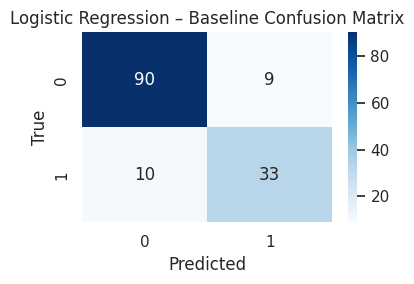

<Figure size 800x500 with 0 Axes>

In [16]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize = (4,3))
sns.heatmap(cm, annot=True, fmt = "d", cmap = "Blues")
plt.title("Logistic Regression – Baseline Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()
plt.savefig("Machine-Learning-2025-2026---Group-Project/images/logistic_regression_confusion_matrix.png",
    dpi=300
)

From our computed confusion matrix, we can say:
- True Negative = 90
  - correctly identified low-risk departments
- False Positives = 9
  - false alarms (low-risk flagged as high-risk)
- **False Negatives**
  - missed high-risk departments (most dangerous error)
- True Positives = 33
  - correctly detected high-risk departments

 Accuracy of 0.866 indicateds overall strong performance, but accuracy alone is not sufficient due to class imbalance.

 Precision of 0.786 implies that our model flag high-risk department 79% of the time. This controls audit cost and false alarms.

 Recall score indicates that our model detects 77% of high risk departments. In other words, we are missing approximately 23% procent which is clearly not **fine** or **trivial** in compliance.

 We have balanced trade-off precision and recall, suitable for metric, which is concluded from calculated F1 score (0.776)


 The Logistic Regression baseline achieves a strong balance between detecting high-risk departments and limiting false alarms, but the presence od false negatives motivates the use of cross validation and more models to improve recall.

## Cross-Validation and Hyperparameter Tuning

### Logistic Regression


In [17]:
cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)

LR_param_grid = { "model__C": [0.01, 0.1, 1, 10],
                 "model__penalty": ["l2"],
                  "model__solver": ["lbfgs"]}
LR_grid = GridSearchCV(
    estimator = LR_baseline,
    param_grid = LR_param_grid,
    cv = cv, scoring = "f1", n_jobs = 1, error_score = "raise")

LR_grid.fit(X_train, y_train)

print("Best Logistic Regression params:", LR_grid.best_params_)
print("Best CV F1-score:", LR_grid.best_score_)

Best Logistic Regression params: {'model__C': 10, 'model__penalty': 'l2', 'model__solver': 'lbfgs'}
Best CV F1-score: 0.8370298075652782


In [18]:
y_pred_LR_tuned = LR_grid.best_estimator_.predict(X_test)
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred_LR_tuned, zero_division = 0)
rec = recall_score(y_test, y_pred_LR_tuned, zero_division = 0)
f1 = f1_score(y_test, y_pred_LR_tuned, zero_division = 0)

print(f"Accuracy :{acc:.3f}")
print(f"Precision :{prec:.3f}")
print(f"Recall :{rec:.3f}")
print(f"F1 :{f1:.3f}")



Accuracy :0.866
Precision :0.805
Recall :0.767
F1 :0.786


In [19]:
LR_tuned_results = pd.DataFrame([{
    "Model":"Logistic Regression (tuned)",
    "Accuracy" : acc,
    "Precision" : prec,
    "Recall": rec,
    "F1" : f1
}])

In [20]:
results_table = pd.concat(
      [baseline_results, pd.DataFrame(LR_tuned_results)],
      ignore_index = True)
results_table

,Model,Accuracy,Precision,Recall,F1
0,Logistic Regression (baseline),0.866197,0.785714,0.767442,0.776471
1,Logistic Regression (tuned),0.866197,0.804878,0.767442,0.785714


Cross-validation identifies a higher regulatisation of parameter (C = 10), indicating that the baseline model was overly constrained.
The tuned Logistic Regression improves the precision-recall trade-off compared to the baseline.

### Random Forest - Hyperparameter Tuning (GridSearchCV)

Random Forest can capture non-linear relationships and feature interactions that Logistic Regression fail to do.

To identify an optimal Random Forest configuration, we perform hyperparameter tuning using GridSearchCV with 5-fold stratified cross-validation. Startification ensures that the proportion of high-risk and low-risk departments is perserved across folds, which is crucial given the class imbalance in the dataset.

The following hyperparameters are tuned:
- **n_estimator**: number of trees in the forest. Larger values improve stability at the cost of computation.
- **max_depth**: maximum depth of each tree, controling model complexity and overfitting
- **min_samples_split**: minimum number of samples required to split an internal node.
- **min_samples_leaf**: minimum number of samples required to be at leaf node, which smooths prediction.
- **max_features**: number of features considered when looking for the best split, affecting tree diversity.

In [21]:
cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)

RF_model = RandomForestClassifier(random_state = 42, n_jobs = -1)

RF_pipeline = Pipeline(steps = [
    ("preprocess", preprocessor),
    ("model", RF_model)
])
RF_param_grid = {
    "model__n_estimators":[200, 500],
    "model__max_depth":[None, 5, 10],
    "model__min_samples_split": [2, 5, 10],
    "model__min_samples_leaf": [1, 2, 4],
    "model__max_features": ["sqrt", "log2"]
}

RF_grid = GridSearchCV( estimator = RF_pipeline, param_grid = RF_param_grid,
                       cv = cv, scoring = "f1", n_jobs = -1, verbose = 1)
RF_grid.fit(X_train, y_train)

print("Best Random Forest params:", RF_grid.best_params_)
print("Best CV F1-score:", RF_grid.best_score_)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best Random Forest params: {'model__max_depth': None, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 1, 'model__min_samples_split': 5, 'model__n_estimators': 200}
Best CV F1-score: 0.9012546000805013


### Preprocessing strategy for Random Forest

Although Random Forest models do not require feature scaling and can naturally handle numerical variables, the dataset contains a mixture of numerical and categorical features.
Categorical values must therefore be encoded before being passed to the model.

To ensure fair and consisten comparison across models, we reuse the same preprocessing pipelinedefined for Logistic Regression. This pipeline performs:
- imputation of missing values for both numerical and categorical features
- standardisation of numerical variables
- one-hot encoding for categorical variables

Reusing the same preprocessing pipeline avoids discrepancies in feature representation rather than differences in data preparation.

In [22]:
y_pred_RF_tuned = RF_grid.best_estimator_.predict(X_test)

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred_RF_tuned, zero_division = 0)
rec = recall_score(y_test, y_pred_RF_tuned, zero_division = 0)
f1 = f1_score(y_test, y_pred_RF_tuned, zero_division = 0)

print(f"Accuracy :{acc:.3f}")
print(f"Precision :{prec:.3f}")
print(f"Recall :{rec:.3f}")
print(f"F1 :{f1:.3f}")

Accuracy :0.866
Precision :0.897
Recall :0.814
F1 :0.854


In [23]:
RF_tuned_results = pd.DataFrame([{
    "Model":"Random Forest (Tuned)",
    "Accuracy" : acc,
    "Precision" : prec,
    "Recall": rec,
    "F1" : f1
}])
results_table = pd.concat(
      [LR_tuned_results, pd.DataFrame(RF_tuned_results)],
      ignore_index = True)
results_table

,Model,Accuracy,Precision,Recall,F1
0,Logistic Regression (tuned),0.866197,0.804878,0.767442,0.785714
1,Random Forest (Tuned),0.866197,0.897436,0.813953,0.853659


### Interpretation of Model Performance Metrics
When comparing Logistic Regression (tuned) and Random Forest(tuned), both models achieve the same overall accuracy (0.866), indicating similar aggregate classification performance. However, accuracy alone masks important differences in error distribution that are critical for compliance risk detection.

Random Forest demonstrates a clear advantage in both precision and recall. The higher precision indicates that Random Forest produces fewer false positives, thereby reducing unnecessary compliance investigations and audit costs. At the same time, the improved recall shows that Random Forest is more effective at identifying high-risk departments, lowering the likelihood of undetected compliance issues.

This improvement is reflected in the F1 score, which increases from 0.786 for Logistic Regresssion to 0.854 for Random Forest. The higher F1 score confirms that Random Forest achieves a superior balance between risk coverage and operational efficiency.

Overall, despite similar accuracy values, Random Forest outperforms Logistic Regression on the metrics most relevant to compliance monitoring, making it a more suitable model for identifying potential non-compliance within the organisation.



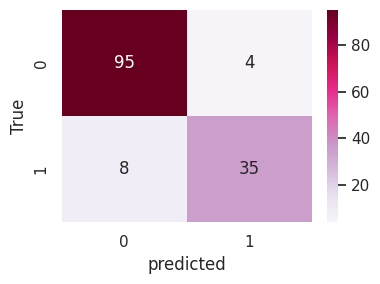

<Figure size 800x500 with 0 Axes>

In [24]:
cm_RF = confusion_matrix(y_test, y_pred_RF_tuned)

plt.figure(figsize =(4,3))
sns.heatmap(cm_RF, annot = True, fmt="d", cmap = "PuRd")
plt.title = ("Random Forest (Tuned) – Confusion Matrix")
plt.xlabel("predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()
plt.savefig("Machine-Learning-2025-2026---Group-Project/images/random_forest_confusion_matrix.png",
    dpi=300
)

### Comparative Analysis of Confusion Matrices
The confusion matrices further illustrates the performance differences betweeen Logistic Regression and Random Forest beyond aggregate metrics.

For **Logistic Regression**, the modell correctly identifies most low-risk departments, but it produces a higher number of false positives (9) and false negatives (10). The presence of false negatives is particularly concearning in a compliance context, as these correspond to high-risk departments that remain undetected and may pose regulatory on reputational risks.

In contrast, **Random Forest** demonstates a more favorable error distribution. The number of false positives is reduced from 9 to 4, indicating fewer unnecessary compliance investigations. At the same time, false negatives decrease from 10 to 8, shoowing an improved ability to detect high-risk departments. This shift reflects more effective balance between risk coverage and operational efficency.

Overall, the Random Forest confusion matrix confirms that the model not only improves predictive performance but alse aligns more closely with compliance objectives by reducing both missed risks and unwaeeanted audits compared to Logistic Regression.